<a href="https://colab.research.google.com/github/cvieirasp/medical-ai-models/blob/main/MedicaAI_TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

O processo será dividido em cinco etapas:

1.   **Definição do problema:** o que queremos que nosso modelo procure? Para isso, precisaremos pensar na patologia que podemos encontrar em uma radiografia de tórax.
2.   **Preparação de dados:** falaremos sobre como manipular nossos dados de uma forma que o modelo de classificação possa entender.
3.   **Treinando um modelo:** usaremos uma tecnologia chamada **TensorFlow** para criar nosso modelo.
4.   **Avaliação do desempenho do modelo:** considerações importantes ao criar um modelo como este.
5.   **Implantação:** enviaremos nosso modelo para um site onde poderemos testá-lo e enviá-lo para outras pessoas.


Importação das bibliotecas e recursos que serão utilizados no modelo.

In [1]:
# O comando abaixo informa ao ambiente IPython para desenhar os gráficos imediatamente após a célula atual. Os gráficos desenhados são exibidos abaixo do código e armazenados no documento do notebook para referência futura.
%matplotlib inline

import sklearn.metrics
import random
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import io
import glob
import scipy.misc
import numpy as np
import pandas as pd
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
import shutil
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import layers
from tensorflow.keras import Model
import matplotlib
from tensorflow.keras.optimizers import RMSprop
import os
import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.image as mpimg

Definição da taxa de aprendizado, repositório onde estão os arquivos necessários para execução do projeto e as propriedades das imagens. Também foi definida uma função para carregar uma imagem no **numpy**.

In [2]:
LEARNING_RATE = 0.0001
repo_url = 'https://github.com/adleberg/medical-ai'
IMAGE_HEIGHT, IMAGE_WIDTH = 256, 256

def load_image_into_numpy_array(image):
    image = image.convert('RGB')
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

Importação dos arquivos necessários para execução do projeto.

In [5]:
print("Baixando arquivos do repositório...")

%cd -q /content
repo_dir_path = os.path.abspath(os.path.join('.', os.path.basename(repo_url)))
!git clone {repo_url} --quiet
%cd -q {repo_dir_path}
!git pull -q

print("Arquivos baixados com sucesso!")

Baixando arquivos do repositório...
Arquivos baixados com sucesso!


##1. Definição do Problema

A princípio, faremos uma busca por `"cardiomegaly"` em uma radiografia de tórax.

Utilizaremos um subconjunto do conjunto de dados [NIH CXR8](https://openaccess.thecvf.com/content_cvpr_2017/papers/Wang_ChestX-ray8_Hospital-Scale_Chest_CVPR_2017_paper.pdf) para este projeto, mas esses princípios aqui se aplicam a qualquer projeto. O conjunto de dados **NIH CXR8** possui apenas algumas descobertas selecionadas em seu conjunto de dados, mas vamos supor que estamos criando um conjunto de dados do zero (usando Montage, por exemplo). É importante salientar que este conjunto de dados também possui **bounding boxes** disponíveis para outra demonstração sobre detecção de objetos.

Screen Shot 2020-11-08 at 1.14.35 PM.png

Acima estão os rótulos disponíveis neste conjunto de dados.

In [6]:
finding = "cardiomegaly"
finding = finding.capitalize()
print(finding)

Cardiomegaly


In [7]:
df = pd.read_csv("/content/medical-ai/labels.csv")
df.head()

,filename,height,width,label,xmin,ymin,xmax,ymax,view
0,00013118_008.jpg,2992,2991,Atelectasis,225.0,547.0,311.0,626.0,PA
1,00014716_007.jpg,3056,2544,Atelectasis,686.0,131.0,871.0,444.0,AP
2,00029817_009.jpg,3056,2544,Atelectasis,221.0,317.0,376.0,533.0,AP
3,00014687_001.jpg,2500,2048,Atelectasis,726.0,494.0,867.0,549.0,AP
4,00017877_001.jpg,2500,2048,Atelectasis,660.0,569.0,860.0,647.0,AP


In [8]:
positives = df.loc[df["label"] == finding]
negatives = df.loc[df["label"] == "No Finding"]
total_positives = len(positives)

if total_positives == 0:
  print('Não foi encontrado nenhum estudo com o nome {}.'.format(finding))
  assert (total_positives > 0)

print('Estudos encontrados: {}.'.format(total_positives))

Estudos encontrados: 146.


In [9]:
TRAIN_RATE = 0.8
TEST_RATE = 0.2
TRAIN_TOTAL = int(total_positives * TRAIN_RATE)
TEST_TOTAL = int(total_positives * TEST_RATE)
print(TRAIN_TOTAL, TEST_TOTAL)

116 29


In [10]:
train_labels = pd.concat([positives[:TRAIN_TOTAL], negatives[:TRAIN_TOTAL]])
test_labels = pd.concat([positives[TRAIN_TOTAL:], negatives[TRAIN_TOTAL:total_positives]])

## 2. Preparação de Dados

Agora que concluímos o que o nosso modelo deve fazer, classificaremos os dados em duas pastas: uma com casos **negativos** e outra com casos **positivos**.

In [11]:
# Criação dos diretórios separados por positivo e negativo.
ROOT_DIR = "/content/medical-ai/images/"

train_positive_dir = "{}{}/train/positive".format(ROOT_DIR, finding)
test_positive_dir = "{}{}/test/positive".format(ROOT_DIR, finding)
train_negative_dir = "{}{}/train/negative".format(ROOT_DIR, finding)
test_negative_dir = "{}{}/test/negative".format(ROOT_DIR, finding)

os.makedirs(train_positive_dir, exist_ok=True)
os.makedirs(test_positive_dir, exist_ok=True)
os.makedirs(train_negative_dir, exist_ok=True)
os.makedirs(test_negative_dir, exist_ok=True)

print("Diretórios criados.")

Diretórios criados.


In [12]:
# Copia as imagens para os novos diretórios para fins de treinamento.
for index, image in positives[:TRAIN_TOTAL].iterrows():
  source = "{}{}".format(ROOT_DIR, image["filename"])
  destiny = "{}/{}".format(train_positive_dir, image["filename"])
  shutil.copy(source, destiny)

for index, image in positives[TRAIN_TOTAL:].iterrows():
  source = "{}{}".format(ROOT_DIR, image["filename"])
  destiny = "{}/{}".format(test_positive_dir, image["filename"])
  shutil.copy(source, destiny)

for index, image in negatives[:TRAIN_TOTAL].iterrows():
  source = "{}{}".format(ROOT_DIR, image["filename"])
  destiny = "{}/{}".format(train_negative_dir, image["filename"])
  shutil.copy(source, destiny)

for index, image in negatives[TRAIN_TOTAL:total_positives].iterrows():
  source = "{}{}".format(ROOT_DIR, image["filename"])
  destiny = "{}/{}".format(test_negative_dir, image["filename"])
  shutil.copy(source, destiny)

print("Imagens copiadas para os diretórios.")

Imagens copiadas para os diretórios.


In [13]:
# Carrega imagens na memória para visualização.
positive_images, negative_images = [], []

for index, row in positives[:6].iterrows():
  image_path = "{}{}".format(ROOT_DIR, row["filename"])
  image_file = Image.open(image_path).resize((IMAGE_WIDTH, IMAGE_HEIGHT))
  positive_images.append(load_image_into_numpy_array(image_file))

for index, row in negatives[:6].iterrows():
  image_path = "{}{}".format(ROOT_DIR, row["filename"])
  image_file = Image.open(image_path).resize((IMAGE_WIDTH, IMAGE_HEIGHT))
  negative_images.append(load_image_into_numpy_array(image_file))

Imagens Positivas:


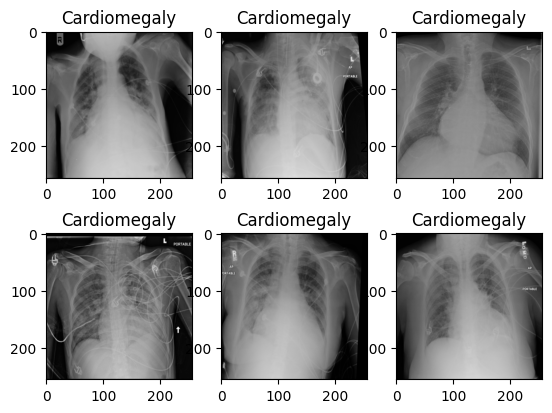

Imagens Negativas:


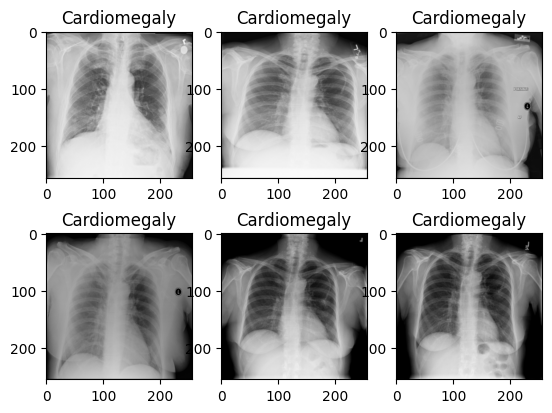

In [14]:
# Plota as imagens.
for index, image in enumerate(positive_images[:6]):
  plt.subplot(2, 3, index+1)
  plt.title(finding)
  plt.imshow(positive_images[index])

print("Imagens Positivas:")
plt.show()

for index, image in enumerate(negative_images[:6]):
  plt.subplot(2, 3, index+1)
  plt.title(finding)
  plt.imshow(negative_images[index])

print("Imagens Negativas:")
plt.show()

## 3. Treinando um modelo

Nessa etapa será utilizada uma tecnologia chamada [Inception V3](https://arxiv.org/abs/1512.00567) para visualizar nossas imagens. Este é um modelo que o Google criou para fazer análise de imagens e divulgou para o público em geral.

Uma coisa que normalmente é feita em visão computacional é pegar um modelo treinado em um conjunto de dados muito grande, executá-lo em seu próprio conjunto de dados menor e extrair as representações intermediárias (features) que o modelo gera. Essas representações são frequentemente informativas para sua própria tarefa de visão computacional, mesmo que a tarefa possa ser bem diferente do problema no qual o modelo original foi treinado. Este modelo específico foi treinado no [ImageNet](http://image-net.org/), um grande conjunto de dados de imagens da web (1,4 milhão de imagens e 1.000 classes).

In [16]:
input_shape = (IMAGE_HEIGHT, IMAGE_WIDTH, 3)
pre_trained_model = InceptionV3(input_shape=input_shape, weights='imagenet', include_top=False)

for layer in pre_trained_model.layers:
  layer.treinable = False

last_layer = pre_trained_model.get_layer('mixed7')
last_output = last_layer.output

# Aplaina a camada de saída em 1 dimensão
x = layers.Flatten()(last_output)
# Adiciona uma camada totalmente conectada com 1024 unidades ocultas e ativação ReLU
x = layers.Dense(1024, activation='relu')(x)
# Adiciona uma taxa de dropout de 0,2
x = layers.Dropout(0.2)(x)
# Adiciona uma camada sigmóide final para classificação
x = layers.Dense(1, activation='sigmoid')(x)

model = Model(pre_trained_model.input, x)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [24]:
# Defina diretórios e arquivos de exemplo
train_dir = os.path.join(ROOT_DIR, finding, 'train')
test_dir = os.path.join(ROOT_DIR, finding, 'test')

train_positive_dir = os.path.join(train_dir, 'positive')
train_negative_dir = os.path.join(train_dir, 'negative')
test_positive_dir = os.path.join(test_dir, 'positive')
test_negative_dir = os.path.join(test_dir, 'negative')

In [25]:
# Adiciona os parâmetros de aumento de dados (data-augmentation) ao ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=40, width_shift_range=0.2, height_shift_range=0.2, shear_range=0.2, zoom_range=0.2, horizontal_flip=False)
# Os dados de teste não devem ser aumentados
val_datagen = ImageDataGenerator(rescale=1./255)

In [26]:
target_size = (IMAGE_WIDTH, IMAGE_HEIGHT)
train_generator = train_datagen.flow_from_directory(train_dir, target_size=target_size, batch_size=1, class_mode='binary')
test_generator = val_datagen.flow_from_directory(test_dir, target_size=target_size, batch_size=1, class_mode='binary')

train_steps = len(os.listdir(train_positive_dir))*2
test_steps = len(os.listdir(test_positive_dir))*2

Found 232 images belonging to 2 classes.
Found 60 images belonging to 2 classes.


###4. Executando o modelo

Por fim, o modelo será treinado usando os recursos extraídos. Serão treinados em todos os 80% dos rótulos e será verificada sua precisão nos 20% restantes.